In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

!pip install -q condacolab
import condacolab

condacolab.install()

import condacolab

condacolab.check()
!conda install -c conda-forge openbabel

condacolab.check()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

✨🍰✨ Everything looks OK!


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture

!pip install py3Dmol
!pip install biopython
!pip install rdkit
import sys
!pip -q install py3Dmol
!pip install git+https://github.com/pablo-arantes/biopandas
!mamba install openmmforcefields -c conda-forge -y
!pip install prolif
!mamba install -c conda-forge openbabel -y
!mamba install -c conda-forge ambertools -y
!mamba install -c conda-forge parmed -y
!pip install --upgrade MDAnalysis
!pip install biopython

import parmed as pmd
from biopandas.pdb import PandasPdb
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdForceFieldHelpers
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
import openbabel
from openbabel import pybel
print("Both openbabel and pybel installed, miracuosly!!!")
import os
import subprocess

import pickle

import numpy as np

from openbabel import pybel
from math import ceil, sin, cos, sqrt, pi
from itertools import combinations


class Featurizer():
    """Calcaulates atomic features for molecules. Features can encode atom type,
    native pybel properties or any property defined with SMARTS patterns

    Attributes
    ----------
    FEATURE_NAMES: list of strings
        Labels for features (in the same order as features)
    NUM_ATOM_CLASSES: int
        Number of atom codes
    ATOM_CODES: dict
        Dictionary mapping atomic numbers to codes
    NAMED_PROPS: list of string
        Names of atomic properties to retrieve from pybel.Atom object
    CALLABLES: list of callables
        Callables used to calculcate custom atomic properties
    SMARTS: list of SMARTS strings
        SMARTS patterns defining additional atomic properties
    """

    def __init__(self, atom_codes=None, atom_labels=None,
                 named_properties=None, save_molecule_codes=True,
                 custom_properties=None, smarts_properties=None,
                 smarts_labels=None):

        """Creates Featurizer with specified types of features. Elements of a
        feature vector will be in a following order: atom type encoding
        (defined by atom_codes), Pybel atomic properties (defined by
        named_properties), molecule code (if present), custom atomic properties
        (defined `custom_properties`), and additional properties defined with
        SMARTS (defined with `smarts_properties`).

        Parameters
        ----------
        atom_codes: dict, optional
            Dictionary mapping atomic numbers to codes. It will be used for
            one-hot encoging therefore if n different types are used, codes
            shpuld be from 0 to n-1. Multiple atoms can have the same code,
            e.g. you can use {6: 0, 7: 1, 8: 1} to encode carbons with [1, 0]
            and nitrogens and oxygens with [0, 1] vectors. If not provided,
            default encoding is used.
        atom_labels: list of strings, optional
            Labels for atoms codes. It should have the same length as the
            number of used codes, e.g. for `atom_codes={6: 0, 7: 1, 8: 1}` you
            should provide something like ['C', 'O or N']. If not specified
            labels 'atom0', 'atom1' etc are used. If `atom_codes` is not
            specified this argument is ignored.
        named_properties: list of strings, optional
            Names of atomic properties to retrieve from pybel.Atom object. If
            not specified ['hyb', 'heavyvalence', 'heterovalence',
            'partialcharge'] is used.
        save_molecule_codes: bool, optional (default True)
            If set to True, there will be an additional feature to save
            molecule code. It is usefeul when saving molecular complex in a
            single array.
        custom_properties: list of callables, optional
            Custom functions to calculate atomic properties. Each element of
            this list should be a callable that takes pybel.Atom object and
            returns a float. If callable has `__name__` property it is used as
            feature label. Otherwise labels 'func<i>' etc are used, where i is
            the index in `custom_properties` list.
        smarts_properties: list of strings, optional
            Additional atomic properties defined with SMARTS patterns. These
            patterns should match a single atom. If not specified, deafult
            patterns are used.
        smarts_labels: list of strings, optional
            Labels for properties defined with SMARTS. Should have the same
            length as `smarts_properties`. If not specified labels 'smarts0',
            'smarts1' etc are used. If `smarts_properties` is not specified
            this argument is ignored.
        """

        # Remember namse of all features in the correct order
        self.FEATURE_NAMES = []

        if atom_codes is not None:
            if not isinstance(atom_codes, dict):
                raise TypeError('Atom codes should be dict, got %s instead'
                                % type(atom_codes))
            codes = set(atom_codes.values())
            for i in range(len(codes)):
                if i not in codes:
                    raise ValueError('Incorrect atom code %s' % i)

            self.NUM_ATOM_CLASSES = len(codes)
            self.ATOM_CODES = atom_codes
            if atom_labels is not None:
                if len(atom_labels) != self.NUM_ATOM_CLASSES:
                    raise ValueError('Incorrect number of atom labels: '
                                     '%s instead of %s'
                                     % (len(atom_labels), self.NUM_ATOM_CLASSES))
            else:
                atom_labels = ['atom%s' % i for i in range(self.NUM_ATOM_CLASSES)]
            self.FEATURE_NAMES += atom_labels
        else:
            self.ATOM_CODES = {}

            metals = ([3, 4, 11, 12, 13] + list(range(19, 32))
                      + list(range(37, 51)) + list(range(55, 84))
                      + list(range(87, 104)))

            # List of tuples (atomic_num, class_name) with atom types to encode.
            atom_classes = [
                (5, 'B'),
                (6, 'C'),
                (7, 'N'),
                (8, 'O'),
                (15, 'P'),
                (16, 'S'),
                (34, 'Se'),
                ([9, 17, 35, 53], 'halogen'),
                (metals, 'metal')
            ]

            for code, (atom, name) in enumerate(atom_classes):
                if type(atom) is list:
                    for a in atom:
                        self.ATOM_CODES[a] = code
                else:
                    self.ATOM_CODES[atom] = code
                self.FEATURE_NAMES.append(name)

            self.NUM_ATOM_CLASSES = len(atom_classes)

        if named_properties is not None:
            if not isinstance(named_properties, (list, tuple, np.ndarray)):
                raise TypeError('named_properties must be a list')
            allowed_props = [prop for prop in dir(pybel.Atom)
                             if not prop.startswith('__')]
            for prop_id, prop in enumerate(named_properties):
                if prop not in allowed_props:
                    raise ValueError(
                        'named_properties must be in pybel.Atom attributes,'
                        ' %s was given at position %s' % (prop_id, prop)
                    )
            self.NAMED_PROPS = named_properties
        else:
            # pybel.Atom properties to save
            self.NAMED_PROPS = ['hyb', 'heavydegree', 'heterodegree',
                                'partialcharge']
        self.FEATURE_NAMES += self.NAMED_PROPS

        if not isinstance(save_molecule_codes, bool):
            raise TypeError('save_molecule_codes should be bool, got %s '
                            'instead' % type(save_molecule_codes))
        self.save_molecule_codes = save_molecule_codes
        if save_molecule_codes:
            # Remember if an atom belongs to the ligand or to the protein
            self.FEATURE_NAMES.append('molcode')

        self.CALLABLES = []
        if custom_properties is not None:
            for i, func in enumerate(custom_properties):
                if not callable(func):
                    raise TypeError('custom_properties should be list of'
                                    ' callables, got %s instead' % type(func))
                name = getattr(func, '__name__', '')
                if name == '':
                    name = 'func%s' % i
                self.CALLABLES.append(func)
                self.FEATURE_NAMES.append(name)

        if smarts_properties is None:
            # SMARTS definition for other properties
            self.SMARTS = [
                '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                '[a]',
                '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                '[r]'
            ]
            smarts_labels = ['hydrophobic', 'aromatic', 'acceptor', 'donor',
                             'ring']
        elif not isinstance(smarts_properties, (list, tuple, np.ndarray)):
            raise TypeError('smarts_properties must be a list')
        else:
            self.SMARTS = smarts_properties

        if smarts_labels is not None:
            if len(smarts_labels) != len(self.SMARTS):
                raise ValueError('Incorrect number of SMARTS labels: %s'
                                 ' instead of %s'
                                 % (len(smarts_labels), len(self.SMARTS)))
        else:
            smarts_labels = ['smarts%s' % i for i in range(len(self.SMARTS))]

        # Compile patterns
        self.compile_smarts()
        self.FEATURE_NAMES += smarts_labels

    def compile_smarts(self):
        self.__PATTERNS = []
        for smarts in self.SMARTS:
            self.__PATTERNS.append(pybel.Smarts(smarts))

    def encode_num(self, atomic_num):
        """Encode atom type with a binary vector. If atom type is not included in
        the `atom_classes`, its encoding is an all-zeros vector.

        Parameters
        ----------
        atomic_num: int
            Atomic number

        Returns
        -------
        encoding: np.ndarray
            Binary vector encoding atom type (one-hot or null).
        """

        if not isinstance(atomic_num, int):
            raise TypeError('Atomic number must be int, %s was given'
                            % type(atomic_num))

        encoding = np.zeros(self.NUM_ATOM_CLASSES)
        try:
            encoding[self.ATOM_CODES[atomic_num]] = 1.0
        except:
            pass
        return encoding

    def find_smarts(self, molecule):
        """Find atoms that match SMARTS patterns.

        Parameters
        ----------
        molecule: pybel.Molecule

        Returns
        -------
        features: np.ndarray
            NxM binary array, where N is the number of atoms in the `molecule`
            and M is the number of patterns. `features[i, j]` == 1.0 if i'th
            atom has j'th property
        """

        if not isinstance(molecule, pybel.Molecule):
            raise TypeError('molecule must be pybel.Molecule object, %s was given'
                            % type(molecule))

        features = np.zeros((len(molecule.atoms), len(self.__PATTERNS)))

        for (pattern_id, pattern) in enumerate(self.__PATTERNS):
            atoms_with_prop = np.array(list(*zip(*pattern.findall(molecule))),
                                       dtype=int) - 1
            features[atoms_with_prop, pattern_id] = 1.0
        return features

    def get_features(self, molecule, molcode=None):
        """Get coordinates and features for all heavy atoms in the molecule.

        Parameters
        ----------
        molecule: pybel.Molecule
        molcode: float, optional
            Molecule type. You can use it to encode whether an atom belongs to
            the ligand (1.0) or to the protein (-1.0) etc.

        Returns
        -------
        coords: np.ndarray, shape = (N, 3)
            Coordinates of all heavy atoms in the `molecule`.
        features: np.ndarray, shape = (N, F)
            Features of all heavy atoms in the `molecule`: atom type
            (one-hot encoding), pybel.Atom attributes, type of a molecule
            (e.g protein/ligand distinction), and other properties defined with
            SMARTS patterns
        """

        if not isinstance(molecule, pybel.Molecule):
            raise TypeError('molecule must be pybel.Molecule object,'
                            ' %s was given' % type(molecule))
        if molcode is None:
            if self.save_molecule_codes is True:
                raise ValueError('save_molecule_codes is set to True,'
                                 ' you must specify code for the molecule')
        elif not isinstance(molcode, (float, int)):
            raise TypeError('motlype must be float, %s was given'
                            % type(molcode))

        coords = []
        features = []
        heavy_atoms = []

        for i, atom in enumerate(molecule):
            # ignore hydrogens and dummy atoms (they have atomicnum set to 0)
            if atom.atomicnum > 1:
                heavy_atoms.append(i)
                coords.append(atom.coords)

                features.append(np.concatenate((
                    self.encode_num(atom.atomicnum),
                    [atom.__getattribute__(prop) for prop in self.NAMED_PROPS],
                    [func(atom) for func in self.CALLABLES],
                )))

        coords = np.array(coords, dtype=np.float32)
        features = np.array(features, dtype=np.float32)
        if self.save_molecule_codes:
            features = np.hstack((features,
                                  molcode * np.ones((len(features), 1))))
        features = np.hstack([features,
                              self.find_smarts(molecule)[heavy_atoms]])

        if np.isnan(features).any():
            raise RuntimeError('Got NaN when calculating features')

        return coords, features

    def to_pickle(self, fname='featurizer.pkl'):
        """Save featurizer in a given file. Featurizer can be restored with
        `from_pickle` method.

        Parameters
        ----------
        fname: str, optional
           Path to file in which featurizer will be saved
        """

        # patterns can't be pickled, we need to temporarily remove them
        patterns = self.__PATTERNS[:]
        del self.__PATTERNS
        try:
            with open(fname, 'wb') as f:
                pickle.dump(self, f)
        finally:
            self.__PATTERNS = patterns[:]

    @staticmethod
    def from_pickle(fname):
        """Load pickled featurizer from a given file

        Parameters
        ----------
        fname: str, optional
           Path to file with saved featurizer

        Returns
        -------
        featurizer: Featurizer object
           Loaded featurizer
        """
        with open(fname, 'rb') as f:
            featurizer = pickle.load(f)
        featurizer.compile_smarts()
        return featurizer


def rotation_matrix(axis, theta):
    """Counterclockwise rotation about a given axis by theta radians"""

    if not isinstance(axis, (np.ndarray, list, tuple)):
        raise TypeError('axis must be an array of floats of shape (3,)')
    try:
        axis = np.asarray(axis, dtype=np.float64)
    except ValueError:
        raise ValueError('axis must be an array of floats of shape (3,)')

    if axis.shape != (3,):
        raise ValueError('axis must be an array of floats of shape (3,)')

    if not isinstance(theta, (float, int)):
        raise TypeError('theta must be a float')

    axis = axis / sqrt(np.dot(axis, axis))
    a = cos(theta / 2.0)
    b, c, d = -axis * sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


# Create matrices for all possible 90* rotations of a box
ROTATIONS = [rotation_matrix([1, 1, 1], 0)]

# about X, Y and Z - 9 rotations
for a1 in range(3):
    for t in range(1, 4):
        axis = np.zeros(3)
        axis[a1] = 1
        theta = t * pi / 2.0
        ROTATIONS.append(rotation_matrix(axis, theta))

# about each face diagonal - 6 rotations
for (a1, a2) in combinations(range(3), 2):
    axis = np.zeros(3)
    axis[[a1, a2]] = 1.0
    theta = pi
    ROTATIONS.append(rotation_matrix(axis, theta))
    axis[a2] = -1.0
    ROTATIONS.append(rotation_matrix(axis, theta))

# about each space diagonal - 8 rotations
for t in [1, 2]:
    theta = t * 2 * pi / 3
    axis = np.ones(3)
    ROTATIONS.append(rotation_matrix(axis, theta))
    for a1 in range(3):
        axis = np.ones(3)
        axis[a1] = -1
        ROTATIONS.append(rotation_matrix(axis, theta))


def rotate(coords, rotation):
    """Rotate coordinates by a given rotation

    Parameters
    ----------
    coords: array-like, shape (N, 3)
        Arrays with coordinates and features for each atoms.
    rotation: int or array-like, shape (3, 3)
        Rotation to perform. You can either select predefined rotation by
        giving its index or specify rotation matrix.

    Returns
    -------
    coords: np.ndarray, shape = (N, 3)
        Rotated coordinates.
    """

    global ROTATIONS

    if not isinstance(coords, (np.ndarray, list, tuple)):
        raise TypeError('coords must be an array of floats of shape (N, 3)')
    try:
        coords = np.asarray(coords, dtype=np.float64)
    except ValueError:
        raise ValueError('coords must be an array of floats of shape (N, 3)')
    shape = coords.shape
    if len(shape) != 2 or shape[1] != 3:
        raise ValueError('coords must be an array of floats of shape (N, 3)')

    if isinstance(rotation, int):
        if rotation >= 0 and rotation < len(ROTATIONS):
            return np.dot(coords, ROTATIONS[rotation])
        else:
            raise ValueError('Invalid rotation number %s!' % rotation)
    elif isinstance(rotation, np.ndarray) and rotation.shape == (3, 3):
        return np.dot(coords, rotation)

    else:
        raise ValueError('Invalid rotation %s!' % rotation)


# TODO: add make_grid variant for GPU

def make_grid(coords, features, grid_resolution=1.0, max_dist=10.0):
    """Convert atom coordinates and features represented as 2D arrays into a
    fixed-sized 3D box.

    Parameters
    ----------
    coords, features: array-likes, shape (N, 3) and (N, F)
        Arrays with coordinates and features for each atoms.
    grid_resolution: float, optional
        Resolution of a grid (in Angstroms).
    max_dist: float, optional
        Maximum distance between atom and box center. Resulting box has size of
        2*`max_dist`+1 Angstroms and atoms that are too far away are not
        included.

    Returns
    -------
    coords: np.ndarray, shape = (M, M, M, F)
        4D array with atom properties distributed in 3D space. M is equal to
        2 * `max_dist` / `grid_resolution` + 1
    """

    try:
        coords = np.asarray(coords, dtype=np.float64)
    except ValueError:
        raise ValueError('coords must be an array of floats of shape (N, 3)')
    c_shape = coords.shape
    if len(c_shape) != 2 or c_shape[1] != 3:
        raise ValueError('coords must be an array of floats of shape (N, 3)')

    N = len(coords)
    try:
        features = np.asarray(features, dtype=np.float64)
    except ValueError:
        raise ValueError('features must be an array of floats of shape (N, F)')
    f_shape = features.shape
    if len(f_shape) != 2 or f_shape[0] != N:
        raise ValueError('features must be an array of floats of shape (N, F)')

    if not isinstance(grid_resolution, (float, int)):
        raise TypeError('grid_resolution must be float')
    if grid_resolution <= 0:
        raise ValueError('grid_resolution must be positive')

    if not isinstance(max_dist, (float, int)):
        raise TypeError('max_dist must be float')
    if max_dist <= 0:
        raise ValueError('max_dist must be positive')

    num_features = f_shape[1]
    max_dist = float(max_dist)
    grid_resolution = float(grid_resolution)

    box_size = ceil(2 * max_dist / grid_resolution + 1)

    # move all atoms to the neares grid point
    grid_coords = (coords + max_dist) / grid_resolution
    grid_coords = grid_coords.round().astype(int)

    # remove atoms outside the box
    in_box = ((grid_coords >= 0) & (grid_coords < box_size)).all(axis=1)
    grid = np.zeros((1, box_size, box_size, box_size, num_features),
                    dtype=np.float32)
    for (x, y, z), f in zip(grid_coords[in_box], features[in_box]):
        grid[0, x, y, z] += f

    return grid

# import tensorflow as tf
from keras.models import Model
from keras.layers import Input,Convolution3D,MaxPooling3D,UpSampling3D,concatenate,BatchNormalization,Activation,Add,Concatenate
from keras import backend as K
from keras.regularizers import l2
from skimage.segmentation import clear_border
from skimage.morphology import closing
# from tfbio.data import Featurizer
from skimage.measure import label
from openbabel import pybel
import openbabel
#from data import *
# import tfbio.net
import numpy as np
class PUResNet(Model):
    def identity_block(self,input_tensor,filters,stage,block,layer=None):
        filter1,filter2,filter3=filters
        if K.image_data_format()=='channels_last':
            bn_axis=4
        else:
            bn_axis=1
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        x=Convolution3D(filters=filter1,kernel_size=1,name=conv_name_base + '2a',kernel_regularizer=l2(1e-4))(input_tensor)
        if layer==None:
            x=BatchNormalization(axis=bn_axis,name=bn_name_base + '2a')(x)
        x=Activation('relu')(x)
        x=Convolution3D(filters=filter2,kernel_size=3,padding='same',name=conv_name_base + '2b',kernel_regularizer=l2(1e-4))(x)
        if layer==None:
            x=BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x=Activation('relu')(x)
        x=Convolution3D(filters=filter3,kernel_size=1, name=conv_name_base + '2c',kernel_regularizer=l2(1e-4))(x)
        if layer==None:
            x=BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
        x=Add()([x,input_tensor])
        x=Activation('relu')(x)
        return x
    def conv_block(self,input_tensor,filters,stage,block,strides=(2,2,2)):
        filters1,filters2,filters3=filters

        if K.image_data_format()=='channels_last':
            bn_axis=4
        else:
            bn_axis=1
        residue=input_tensor
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        x=Convolution3D(filters1,kernel_size=1,strides=strides,name=conv_name_base + '2a',kernel_regularizer=l2(1e-4))(input_tensor)
        x=BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x=Activation('relu')(x)
        x=Convolution3D(filters2,kernel_size=3,padding='same', name=conv_name_base + '2b',kernel_regularizer=l2(1e-4))(x)
        x=BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        x=Activation('relu')(x)
        x=Convolution3D(filters3,kernel_size=1,name=conv_name_base + '2c',kernel_regularizer=l2(1e-4))(x)
        x=BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
        residue=Convolution3D(filters3,kernel_size=1,strides=strides,name=conv_name_base + '1',kernel_regularizer=l2(1e-4))(input_tensor)
        residue=BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(residue)
        x=Add()([x,residue])
        x=Activation('relu')(x)

        return x

    def up_conv_block(self,input_tensor,filters,stage,block,stride=(1,1,1),size=(2,2,2),padding='same',layer=None):
        filters1,filters2,filters3=filters
        shortcut=input_tensor
        if K.image_data_format()=='channels_last':
            bn_axis=4
        else:
            bn_axis=1
        up_conv_name_base = 'up' + str(stage) + block + '_branch'
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        x=UpSampling3D(size,name=up_conv_name_base + '2a')(input_tensor)
        x=Convolution3D(filters1,kernel_size=1, strides=stride,name=conv_name_base + '2a',kernel_regularizer=l2(1e-4))(x)
        if layer==None:
            x=BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x=Activation('relu')(x)
        x=Convolution3D(filters2,kernel_size=3,padding=padding,name=conv_name_base + '2b',kernel_regularizer=l2(1e-4))(x)
        if layer==None:
            x=BatchNormalization(axis=bn_axis,name=bn_name_base + '2b')(x)
        x=Activation('relu')(x)
        x=Convolution3D(filters3,kernel_size=1,name=conv_name_base + '2c',kernel_regularizer=l2(1e-4))(x)
        if layer==None:
            x=BatchNormalization(axis=bn_axis,name=bn_name_base + '2c')(x)
        shortcut=UpSampling3D(size, name=up_conv_name_base + '1')(input_tensor)
        shortcut=Convolution3D(filters3,kernel_size=1,strides=stride,padding=padding,name=conv_name_base + '1',kernel_regularizer=l2(1e-5))(shortcut)
        if layer==None:
            shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
        x=Add()([x,shortcut])
        x=Activation('relu')(x)
        return x
    def __init__(self,featurizer=Featurizer(save_molecule_codes=False),scale=0.5,max_dist=35,**kwargs):
        self.featurizer=featurizer
        self.scale=scale
        self.max_dist=max_dist
        f=18
        b_axis=4
        inputs = Input((36, 36, 36, 18), name='input')
        x=self.conv_block(inputs,[f, f, f ],stage=2,block='a',strides=(1,1,1))
        x=self.identity_block(x,[f, f, f ],stage=2,block='b')
        x1=self.identity_block(x,[f, f, f ],stage=2,block='c')
        x=self.conv_block(x,[f*2, f*2, f * 2],stage=4,block='a',strides=(2,2,2))
        x=self.identity_block(x,[f*2,f*2,f * 2],stage=4,block='b')
        x2=self.identity_block(x,[f*2,f*2,f * 2],stage=4,block='f')
        x=self.conv_block(x,[f*4, f*4, f * 4],stage=5,block='a',strides=(2,2,2))
        x=self.identity_block(x,[f*4, f*4, f *4],stage=5,block='b')
        x3=self.identity_block(x,[f*4, f*4, f * 4],stage=5,block='c')
        x=self.conv_block(x,[f*8, f*8, f *8],stage=6,block='a',strides=(3,3,3))
        x=self.identity_block(x,[f*8, f*8, f *8],stage=6,block='b')
        x4=self.identity_block(x,[f*8, f*8, f * 8],stage=6,block='c')
        x=self.conv_block(x,[f*16, f*16, f *16],stage=7,block='a',strides=(3,3,3))
        x=self.identity_block(x,[f*16, f*16, f *16],stage=7,block='b')
        x = self.up_conv_block(x, [f * 16, f * 16, f * 16], stage=8, block='a',size=(3,3,3),padding='same')
        x = self.identity_block(x, [f * 16, f * 16, f * 16], stage=8, block='b')
        x = Concatenate(axis=4)([x, x4])
        x = self.up_conv_block(x, [f * 8, f * 8, f * 8], stage=9, block='a',size=(3,3,3),stride=(1,1,1))
        x = self.identity_block(x, [f * 8, f * 8, f * 8], stage=9, block='b')
        x = Concatenate(axis=4)([x, x3])
        x = self.up_conv_block(x,  [f * 4, f*4 , f*4 ], stage=10, block='a',size=(2,2,2),stride=(1,1,1))
        x = self.identity_block(x,  [f * 4, f*4 , f*4 ], stage=10, block='b')
        x = Concatenate(axis=4)([x,x2])
        x = self.up_conv_block(x,  [f*2 , f*2 , f*2 ], stage=11, block='a',size=(2,2,2),stride=(1,1,1))
        x = self.identity_block(x,  [f*2 , f*2 , f*2 ], stage=11, block='b')
        x = Concatenate(axis=4)([x,x1])
        outputs = Convolution3D(
                filters=1,
                kernel_size=1,
                kernel_regularizer=l2(1e-4),
                activation='sigmoid',
                name='pocket'
            )(x)
        super().__init__(inputs=inputs,outputs=outputs,**kwargs)
    def get_pockets_segmentation(self, density, threshold=0.5, min_size=50):
        if len(density) != 1:
            raise ValueError('segmentation of more than one pocket is not'
                             ' supported')

        voxel_size = (1 / self.scale) ** 3
        bw = closing((density[0] > threshold).any(axis=-1))
        cleared = clear_border(bw)

        label_image, num_labels = label(cleared, return_num=True)
        for i in range(1, num_labels + 1):
            pocket_idx = (label_image == i)
            pocket_size = pocket_idx.sum() * voxel_size
            if pocket_size < min_size:
                label_image[np.where(pocket_idx)] = 0

        return label_image
    def pocket_density_from_mol(self, mol):
        if not isinstance(mol, pybel.Molecule):
            raise TypeError('mol should be a pybel.Molecule object, got %s '
                            'instead' % type(mol))
        if self.featurizer is None:
            raise ValueError('featurizer must be set to make predistions for '
                             'molecules')
        if self.scale is None:
            raise ValueError('scale must be set to make predistions')
        prot_coords, prot_features = self.featurizer.get_features(mol)
        centroid = prot_coords.mean(axis=0)
        prot_coords -= centroid
        resolution = 1. / self.scale
        x = make_grid(prot_coords, prot_features,
                                 max_dist=self.max_dist,
                                 grid_resolution=resolution)
        density = self.predict(x)
        origin = (centroid - self.max_dist)
        step = np.array([1.0 / self.scale] * 3)
        return density, origin, step
    def save_pocket_mol2(self,mol,path,format,**pocket_kwargs):
        density, origin, step = self.pocket_density_from_mol(mol)
        pockets = self.get_pockets_segmentation(density, **pocket_kwargs)
        i=0
        for pocket_label in range(1, pockets.max() + 1):
            indices = np.argwhere(pockets == pocket_label).astype('float')
            indices *= step
            indices += origin
            mol=openbabel.OBMol()
            for idx in indices:
                a=mol.NewAtom()
                a.SetVector(float(idx[0]),float(idx[1]),float(idx[2]))
            p_mol=pybel.Molecule(mol)
            p_mol.write(format,path+'/pocket'+str(i)+'.'+format)
            i+=1

featurizer = Featurizer(save_molecule_codes = False)

scale=0.5
max_dist=35
file_format = 'pdb'

grid_resolution=1.0
scale=0.5
grid_size=36

threshold = 0.5
resolution = 1. / scale

def get_pockets_segmentation(density, threshold=0.5, min_size=50):
    if len(density) != 1:
        raise ValueError('segmentation of more than one pocket is not supported')

    voxel_size = (1 / scale) ** 3
    bw = closing((density[0] > threshold).any(axis=-1))
    cleared = clear_border(bw)

    label_image, num_labels = label(cleared, return_num=True)
    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image


def pocket_density_from_mol(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = model.predict(x)
    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)
    return density, origin, step

def save_pocket_mol2(mol, path, format, **pocket_kwargs):
    density, origin, step = pocket_density_from_mol(mol)
    pockets = get_pockets_segmentation(density, **pocket_kwargs)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        p_mol.write(format, path + '/pocket' + str(i) + '.' + format)
        i += 1

import numpy as np
from openbabel import pybel
from scipy.ndimage import gaussian_filter

def read_molecule(file_path):
    return next(pybel.readfile('mol2', file_path))

def generate_density_from_mol2(protein_mol2_path, site_mol2_path, featurizer, scale=0.5, max_dist=35, grid_size=36, sigma=1.0):
    protein_mol = read_molecule(protein_mol2_path)
    site_mol = read_molecule(site_mol2_path)

    # Extract coordinates
    protein_coords = np.array([atom.coords for atom in protein_mol.atoms])
    site_coords = np.array([atom.coords for atom in site_mol.atoms])

    # Define the grid
    step_size = 2.0
    grid_shape = (grid_size, grid_size, grid_size)
    grid_extent = np.array(grid_shape) * step_size

    # Compute the center of the protein coordinates
    protein_center = protein_coords.mean(axis=0)

    # Compute the origin so that the grid is centered around the protein
    origin = protein_center - (grid_extent / 2)

    density_grid = np.zeros(grid_shape)

    # Adjust site coordinates to grid indices
    site_indices = ((site_coords - origin) / step_size).astype(int)
    for idx in site_indices:
        if np.all((0 <= idx) & (idx < grid_size)):
            density_grid[tuple(idx)] += 1

    # Optionally apply Gaussian smoothing to simulate density
    density_grid = gaussian_filter(density_grid, sigma=sigma)

    # Add an additional dimension to match the shape (36, 36, 36, 1)
    density_grid = np.expand_dims(density_grid, axis=-1)

    density_grid = np.where(density_grid > 0.5, 1.0, 0.0)

    step = np.array([step_size, step_size, step_size])

    return density_grid, origin, step


import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    """
    Compute the Dice coefficient given the true and predicted density grids.
    """
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    volume_true = tf.reduce_sum(y_true_flat)
    volume_pred = tf.reduce_sum(y_pred_flat)

    dice = (2. * intersection) / (volume_true + volume_pred + tf.keras.backend.epsilon())
    return dice

def dice_loss(y_true, y_pred):
    """
    Compute the Dice loss given the true and predicted density grids.
    """
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred):
    """
    Compute the Intersection over Union (IoU) given the true and predicted density grids.
    Apply a threshold to the predicted density grid to convert it to binary values.
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection

    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

In [ ]:
#@title **RAPID-Net**
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Activation, add, SpatialDropout3D, GlobalAveragePooling3D, Reshape, Dense, multiply, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

def identity_block(input_tensor, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = -1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv3D(filters1, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters2, (3, 3, 3), padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters3, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = -1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv3D(filters1, (1, 1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters2, (3, 3, 3), padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters3, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv3D(filters3, (1, 1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = GlobalAveragePooling3D()(input_tensor)
    se = Reshape((1, 1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = multiply([input_tensor, se])
    return x

def RAPID_Net(input_shape=(36, 36, 36, 18), filters=18, dropout_rate=0.5, l2_lambda=1e-3):
    params = {'kernel_size': 3, 'activation': 'relu', 'padding': 'same', 'kernel_regularizer': l2(l2_lambda)}

    inputs = Input(shape=input_shape, name='input')

    x = conv_block(inputs, [filters, filters, filters], stage=2, block='a', strides=(1, 1, 1))
    x1 = identity_block(x, [filters, filters, filters], stage=2, block='b')

    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(x1)

    x = conv_block(pool1, [filters*2, filters*2, filters*2], stage=4, block='a', strides=(1, 1, 1))
    x2 = identity_block(x, [filters*2, filters*2, filters*2], stage=4, block='b')

    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(x2)

    x = conv_block(pool2, [filters*4, filters*4, filters*4], stage=5, block='a', strides=(1, 1, 1))
    x3 = identity_block(x, [filters*4, filters*4, filters*4], stage=5, block='b')

    pool3 = MaxPooling3D(pool_size=(3, 3, 3))(x3)

    x = conv_block(pool3, [filters*8, filters*8, filters*8], stage=6, block='a', strides=(1, 1, 1))
    x4 = identity_block(x, [filters*8, filters*8, filters*8], stage=6, block='b')

    pool4 = MaxPooling3D(pool_size=(3, 3, 3))(x4)

    x = conv_block(pool4, [filters*16, filters*16, filters*16], stage=7, block='a', strides=(1, 1, 1))
    x = identity_block(x, [filters*16, filters*16, filters*16], stage=7, block='b')

    x = se_block(x)

    up6 = concatenate([UpSampling3D(size=(3, 3, 3))(x), x4], axis=-1)
    conv6 = Conv3D(filters=filters*8, **params)(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    conv6 = Conv3D(filters=filters*8, **params)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([UpSampling3D(size=(3, 3, 3))(conv6), x3], axis=-1)
    conv7 = Conv3D(filters=filters*4, **params)(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    conv7 = Conv3D(filters=filters*4, **params)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = concatenate([UpSampling3D(size=(2, 2, 2))(conv7), x2], axis=-1)
    conv8 = Conv3D(filters=filters*2, **params)(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    conv8 = Conv3D(filters=filters*2, **params)(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = concatenate([UpSampling3D(size=(2, 2, 2))(conv8), x1], axis=-1)
    conv9 = Conv3D(filters=filters, **params)(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    conv9 = Conv3D(filters=filters, **params)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    outputs = Conv3D(filters=1, kernel_size=1, kernel_regularizer=l2(1e-4), activation='relu', name='pocket')(conv9)

    model = Model(inputs=inputs, outputs=outputs, name='My_Net')
    return model

In [ ]:
#@title **Load the weights**

RAPID_Net_run1 = RAPID_Net()
RAPID_Net_run1.load_weights('/content/gdrive/MyDrive/PUResNet/Combined_UNCUT_preprocessing/Runs/Soft_Dice_Relu_5020_Run_1.keras')

RAPID_Net_run2 = RAPID_Net()
RAPID_Net_run2.load_weights('/content/gdrive/MyDrive/PUResNet/Combined_UNCUT_preprocessing/Runs/Soft_Dice_Relu_5020_Run_2.keras')

RAPID_Net_run3 = RAPID_Net()
RAPID_Net_run3.load_weights('/content/gdrive/MyDrive/PUResNet/Combined_UNCUT_preprocessing/Runs/Soft_Dice_Relu_5020_Run_3.keras')

RAPID_Net_run4 = RAPID_Net()
RAPID_Net_run4.load_weights('/content/gdrive/MyDrive/PUResNet/Combined_UNCUT_preprocessing/Runs/Soft_Dice_Relu_5020_Run_4.keras')

RAPID_Net_run5 = RAPID_Net()
RAPID_Net_run5.load_weights('/content/gdrive/MyDrive/PUResNet/Combined_UNCUT_preprocessing/Runs/Soft_Dice_Relu_5020_Run_5.keras')

In [ ]:
def pocket_density_from_mol_RAPID_Net_run1(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run1.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run2(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run2.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run3(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run3.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run4(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run4.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run5(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run5.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

from skimage.morphology import closing, label
from skimage.segmentation import clear_border
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt


def minimal_pockets_segmentation(density1, density2, density3, density4, density5, threshold=0.5, min_size=10, scale=0.5):
    # Fixed version

    voxel_size = (1 / scale) ** 3

    # Threshold densities
    bw1 = closing((density1[0] > threshold).any(axis=-1))
    bw2 = closing((density2[0] > threshold).any(axis=-1))
    bw3 = closing((density3[0] > threshold).any(axis=-1))
    bw4 = closing((density4[0] > threshold).any(axis=-1))
    bw5 = closing((density5[0] > threshold).any(axis=-1))

    # Combine masks with permissive threshold
    combined_bw = np.sum([bw1, bw2, bw3, bw4, bw5], axis=0) >= 1

    # Apply morphological closing to reduce fragmentation
    combined_bw = ndi.binary_closing(combined_bw, structure=np.ones((3, 3, 3)))

    cleared = clear_border(combined_bw)

    label_image, num_labels = label(cleared, return_num=True)

    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image

def ensembled_pockets_segmentation(density1, density2, density3, density4, density5, threshold=0.5, min_size=50, scale=0.5):

    voxel_size = (1 / scale) ** 3

    # Threshold densities
    bw1 = closing((density1[0] > threshold).any(axis=-1))
    bw2 = closing((density2[0] > threshold).any(axis=-1))
    bw3 = closing((density3[0] > threshold).any(axis=-1))
    bw4 = closing((density4[0] > threshold).any(axis=-1))
    bw5 = closing((density5[0] > threshold).any(axis=-1))

    # Combine masks with stricter threshold (majority rule)
    combined_bw = np.sum([bw1, bw2, bw3, bw4, bw5], axis=0) >= 3

    # Apply morphological closing to reduce fragmentation
    combined_bw = ndi.binary_closing(combined_bw, structure=np.ones((3, 3, 3)))

    cleared = clear_border(combined_bw)

    label_image, num_labels = label(cleared, return_num=True)

    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image


def save_pocket_mol2_RAPID_Net_Majority(mol, path, format, **pocket_kwargs):

    density1, origin1, step1 = pocket_density_from_mol_RAPID_Net_run1(mol)
    density1 = np.clip(density1, 0, 1)

    density2, origin2, step2 = pocket_density_from_mol_RAPID_Net_run2(mol)
    density2 = np.clip(density2, 0, 1)

    density3, origin3, step3 = pocket_density_from_mol_RAPID_Net_run3(mol)
    density3 = np.clip(density3, 0, 1)

    density4, origin4, step4 = pocket_density_from_mol_RAPID_Net_run4(mol)
    density4 = np.clip(density4, 0, 1)

    density5, origin5, step5 = pocket_density_from_mol_RAPID_Net_run5(mol)
    density5 = np.clip(density5, 0, 1)

    pockets = ensembled_pockets_segmentation(density1, density2, density3, density4, density5, threshold=0.5, min_size=50, scale=0.5)

    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step1
        indices += origin1
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)

        p_mol.write(format, path + '/pocket_RAPID_Majority' + str(i) + '.' + format)
        i += 1

def save_pocket_mol2_RAPID_Net_Minimal(mol, path, format, **pocket_kwargs):

    density1, origin1, step1 = pocket_density_from_mol_RAPID_Net_run1(mol)
    density1 = np.clip(density1, 0, 1)

    density2, origin2, step2 = pocket_density_from_mol_RAPID_Net_run2(mol)
    density2 = np.clip(density2, 0, 1)

    density3, origin3, step3 = pocket_density_from_mol_RAPID_Net_run3(mol)
    density3 = np.clip(density3, 0, 1)

    density4, origin4, step4 = pocket_density_from_mol_RAPID_Net_run4(mol)
    density4 = np.clip(density4, 0, 1)

    density5, origin5, step5 = pocket_density_from_mol_RAPID_Net_run5(mol)
    density5 = np.clip(density5, 0, 1)

    pockets = minimal_pockets_segmentation(density1, density2, density3, density4, density5, threshold=0.5, min_size=50, scale=0.5)

    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step1
        indices += origin1
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)

        p_mol.write(format, path + '/pocket_RAPID_Minimal' + str(i) + '.' + format)
        i += 1

In [ ]:
prot_pdb_file_path = '/content/gdrive/MyDrive/Interpretation_cavityALL/1AZM/1azm_protein.pdb'
mol = next(pybel.readfile(file_format, prot_pdb_file_path))
o_path = '/content/gdrive/MyDrive/Interpretation_cavityALL/1AZM'

file_format = 'pdb'
output_format = 'pdb'
save_pocket_mol2_RAPID_Net_Minimal(mol, o_path, output_format)
save_pocket_mol2_RAPID_Net_Majority(mol, o_path, output_format)

In [ ]:
import os

def process_proteins_in_subfolders(base_dir):
    """
    Iterate through subfolders, predict pockets for each protein, and save results.

    Args:
        base_dir (str): Path to the base directory containing subfolders.
    """
    file_format = 'pdb'
    output_format = 'pdb'

    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file):
                print(f"Processing protein file: {protein_file}")

                mol = next(pybel.readfile(file_format, protein_file))

                save_pocket_mol2_Mk4d2_Minimal(mol, subfolder_path, output_format)
                save_pocket_mol2_Mk4d2_Majority(mol, subfolder_path, output_format)

                print(f"Pockets saved for protein in subfolder: {subfolder_path}")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2"
process_proteins_in_subfolders(base_directory)

Processing protein file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/protein.pdb
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Pockets saved for protein in subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv
Processing protein file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/protein.pdb
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Pockets saved for protein in subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge
Processing protein file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1imb/protein.pdb
1

In [ ]:
import os
from openbabel import pybel

def count_atoms_in_pocket(file_path):
    """
    Count the number of atoms in a pocket file.

    Args:
        file_path (str): Path to the pocket file.

    Returns:
        int: Number of atoms in the pocket file.
    """
    try:
        mol = next(pybel.readfile("pdb", file_path))
        return len(list(mol.atoms))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return 0

def erase_empty_pockets(base_dir):
    """
    Erase all pocket files that have zero atoms in their structure.

    Args:
        base_dir (str): Path to the base directory containing subfolders.
    """
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if "pocket" in file.lower() and file.endswith(".pdb"):
                    pocket_file_path = os.path.join(subfolder_path, file)
                    atom_count = count_atoms_in_pocket(pocket_file_path)

                    if atom_count == 0:
                        os.remove(pocket_file_path)
                        print(f"Deleted empty pocket file: {pocket_file_path}")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2"
erase_empty_pockets(base_directory)

Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Minimal2.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Minimal6.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Minimal7.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Majority0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Majority1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge/pocket_RAPID_Majority3.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1imb/pocket_RAPID_Minimal1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PU

In [ ]:
def save_pocket_mol2_RAPID_Model_1(mol, path, format):
    density, origin, step = pocket_density_from_mol_Mk4d2_run1(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_RAPID_Model_1_Minimal' + str(i) + '.' + format)
        i += 1

In [ ]:
from openbabel import pybel

base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2"
if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_RAPID_Model_1(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


/usr/local/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━

In [ ]:
import os
from openbabel import pybel

def count_atoms_in_pocket(file_path):
    """
    Count the number of atoms in a pocket file.

    Args:
        file_path (str): Path to the pocket file.

    Returns:
        int: Number of atoms in the pocket file.
    """
    try:
        mol = next(pybel.readfile("pdb", file_path))
        return len(list(mol.atoms))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return 0

def erase_empty_pockets(base_dir):
    """
    Erase all pocket files that have zero atoms in their structure.

    Args:
        base_dir (str): Path to the base directory containing subfolders.
    """
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if "pocket" in file.lower() and file.endswith(".pdb"):
                    pocket_file_path = os.path.join(subfolder_path, file)
                    atom_count = count_atoms_in_pocket(pocket_file_path)

                    if atom_count == 0:
                        os.remove(pocket_file_path)
                        print(f"Deleted empty pocket file: {pocket_file_path}")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2"
erase_empty_pockets(base_directory)

Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1pdz/pocket_RAPID_Model_1_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1krn/pocket_RAPID_Model_1_Minimal3.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1krn/pocket_RAPID_Model_1_Minimal4.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1pso/pocket_RAPID_Model_1_Minimal1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1pso/pocket_RAPID_Model_1_Minimal2.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1psn/pocket_RAPID_Model_1_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1ivd/pocket_RAPID_Model_1_Minimal1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1ivd/pocket_RAPID_Model_1_Minimal2.pdb


In [ ]:
def save_pocket_mol2_RAPID_Model_2(mol, path, format):
    density, origin, step = pocket_density_from_mol_Mk4d2_run2(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_RAPID_Model_2_Minimal' + str(i) + '.' + format)
        i += 1


from openbabel import pybel

base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2"

if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_RAPID_Model_2(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2"
erase_empty_pockets(base_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


/usr/local/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━

In [ ]:
def save_pocket_mol2_RAPID_Model_3(mol, path, format):
    density, origin, step = pocket_density_from_mol_Mk4d2_run3(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_RAPID_Model_3_Minimal' + str(i) + '.' + format)
        i += 1


from openbabel import pybel

base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2"

if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_RAPID_Model_3(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2"
erase_empty_pockets(base_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


/usr/local/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━

In [ ]:
def save_pocket_mol2_RAPID_Model_4(mol, path, format):
    density, origin, step = pocket_density_from_mol_Mk4d2_run4(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_RAPID_Model_4_Minimal' + str(i) + '.' + format)
        i += 1

from openbabel import pybel
base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2"

if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_RAPID_Model_4(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2"
erase_empty_pockets(base_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


/usr/local/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━

In [ ]:
def save_pocket_mol2_RAPID_Model_5(mol, path, format):
    density, origin, step = pocket_density_from_mol_Mk4d2_run5(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_RAPID_Model_5_Minimal' + str(i) + '.' + format)
        i += 1


from openbabel import pybel

base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2"
if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_RAPID_Model_5(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2"
erase_empty_pockets(base_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


/usr/local/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━

In [ ]:
PUResNet_model = PUResNet()
PUResNet_model.load_weights('/content/gdrive/MyDrive/PUResNet/whole_trained_model1_converted.h5')

In [ ]:
def pocket_density_from_mol_PUResNet(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = PUResNet_model.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def get_pockets_segmentation(density, threshold=0.5, min_size=50):
    if len(density) != 1:
        raise ValueError('segmentation of more than one pocket is not supported')

    voxel_size = (1 / scale) ** 3
    bw = closing((density[0] > threshold).any(axis=-1))
    cleared = clear_border(bw)

    label_image, num_labels = label(cleared, return_num=True)
    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image

def save_pocket_mol2_PUResNet(mol, path, format):
    density, origin, step = pocket_density_from_mol_PUResNet(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_PUResNet_Minimal' + str(i) + '.' + format)
        i += 1

In [ ]:
prot_pdb_file_path = '/content/gdrive/MyDrive/Interpretation_cavityALL/Additional/1RCW/1RCW_assembly1_protein.pdb'
mol = next(pybel.readfile(file_format, prot_pdb_file_path))
o_path = '/content/gdrive/MyDrive/Interpretation_cavityALL/Additional/1RCW'

file_format = 'pdb'
output_format = 'pdb'
save_pocket_mol2_PUResNet(mol, o_path, output_format)

In [ ]:
from openbabel import pybel

base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2"

if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_PUResNet(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━

In [ ]:
import os
from openbabel import pybel

def count_atoms_in_pocket(file_path):
    """
    Count the number of atoms in a pocket file.

    Args:
        file_path (str): Path to the pocket file.

    Returns:
        int: Number of atoms in the pocket file.
    """
    try:
        mol = next(pybel.readfile("pdb", file_path))
        return len(list(mol.atoms))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return 0

def erase_empty_pockets(base_dir):
    """
    Erase all pocket files that have zero atoms in their structure.

    Args:
        base_dir (str): Path to the base directory containing subfolders.
    """
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if "pocket" in file.lower() and file.endswith(".pdb"):
                    pocket_file_path = os.path.join(subfolder_path, file)
                    atom_count = count_atoms_in_pocket(pocket_file_path)

                    if atom_count == 0:
                        os.remove(pocket_file_path)
                        print(f"Deleted empty pocket file: {pocket_file_path}")

base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2"
erase_empty_pockets(base_directory)

In [ ]:
from keras.models import Model
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling3D, concatenate
from keras.regularizers import l2

def build_Kalasanty(l2_lambda=1e-4):

    params = {
        'kernel_size': 3,
        'activation': 'relu',
        'padding': 'same',
        'kernel_regularizer': l2(l2_lambda)
    }

    input_shape=(36, 36, 36, 18)

    inputs = Input(shape=input_shape, name='input')

    conv1 = Convolution3D(filters=32, **params)(inputs)
    conv1 = Convolution3D(filters=32, **params)(conv1)
    pool1 = MaxPooling3D(pool_size=2)(conv1)

    conv2 = Convolution3D(filters=64, **params)(pool1)
    conv2 = Convolution3D(filters=64, **params)(conv2)
    pool2 = MaxPooling3D(pool_size=2)(conv2)

    conv3 = Convolution3D(filters=128, **params)(pool2)
    conv3 = Convolution3D(filters=128, **params)(conv3)
    pool3 = MaxPooling3D(pool_size=3)(conv3)

    conv4 = Convolution3D(filters=256, **params)(pool3)
    conv4 = Convolution3D(filters=256, **params)(conv4)
    pool4 = MaxPooling3D(pool_size=3)(conv4)

    conv5 = Convolution3D(filters=512, **params)(pool4)
    conv5 = Convolution3D(filters=512, **params)(conv5)

    up6 = concatenate([UpSampling3D(size=3)(conv5), conv4], axis=4)
    conv6 = Convolution3D(filters=256, **params)(up6)
    conv6 = Convolution3D(filters=256, **params)(conv6)

    up7 = concatenate([UpSampling3D(size=3)(conv6), conv3], axis=4)
    conv7 = Convolution3D(filters=128, **params)(up7)
    conv7 = Convolution3D(filters=128, **params)(conv7)

    up8 = concatenate([UpSampling3D(size=2)(conv7), conv2], axis=4)
    conv8 = Convolution3D(filters=64, **params)(up8)
    conv8 = Convolution3D(filters=64, **params)(conv8)

    up9 = concatenate([UpSampling3D(size=2)(conv8), conv1], axis=4)
    conv9 = Convolution3D(filters=32, **params)(up9)
    conv9 = Convolution3D(filters=32, **params)(conv9)

    outputs = Convolution3D(filters=1, kernel_size=1, kernel_regularizer=l2(1e-4), activation='sigmoid', name='pocket')(conv9)

    model = Model(inputs=inputs, outputs=outputs, name='My_Net')

    return model

In [ ]:
Kalasanty_model = build_Kalasanty(l2_lambda=1e-4)
Kalasanty_model.load_weights('/content/gdrive/MyDrive/PUResNet/model_scpdb2017_converted.h5')

In [ ]:
def pocket_density_from_mol_Kalasanty(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = Kalasanty_model.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def get_pockets_segmentation(density, threshold=0.5, min_size=50):
    if len(density) != 1:
        raise ValueError('segmentation of more than one pocket is not supported')

    voxel_size = (1 / scale) ** 3
    bw = closing((density[0] > threshold).any(axis=-1))
    cleared = clear_border(bw)

    label_image, num_labels = label(cleared, return_num=True)
    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image

def save_pocket_mol2_Kalasanty(mol, path, format):
    density, origin, step = pocket_density_from_mol_Kalasanty(mol)
    pockets = get_pockets_segmentation(density, threshold=0.5, min_size=50)
    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step
        indices += origin
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)
        # call the pocket pocket_thr05_Minimal instead to simplify
        #the code and avoid renaming
        p_mol.write(format, path + '/pocket_Kalasanty_Minimal' + str(i) + '.' + format)
        i += 1


In [ ]:
from openbabel import pybel

base_folder = "/content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2"

if os.path.exists(base_folder):
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            protein_file_path = os.path.join(subfolder_path, "protein.pdb")
            if os.path.exists(protein_file_path):
                try:
                    mol = next(pybel.readfile("pdb", protein_file_path))
                    save_pocket_mol2_Kalasanty(mol, subfolder_path, "pdb")
                except Exception as e:
                    print(f"Error processing file {protein_file_path}: {e}")
            else:
                print(f"protein.pdb not found in subfolder: {subfolder}")
else:
    print(f"The folder {base_folder} does not exist. Please check the path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
protein.pdb not found in subfolder: .ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━

In [ ]:
import os
from openbabel import pybel

def count_atoms_in_pocket(file_path):
    """
    Count the number of atoms in a pocket file.

    Args:
        file_path (str): Path to the pocket file.

    Returns:
        int: Number of atoms in the pocket file.
    """
    try:
        mol = next(pybel.readfile("pdb", file_path))
        return len(list(mol.atoms))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return 0

def erase_empty_pockets(base_dir):
    """
    Erase all pocket files that have zero atoms in their structure.

    Args:
        base_dir (str): Path to the base directory containing subfolders.
    """
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if "pocket" in file.lower() and file.endswith(".pdb"):
                    pocket_file_path = os.path.join(subfolder_path, file)
                    atom_count = count_atoms_in_pocket(pocket_file_path)

                    if atom_count == 0:
                        os.remove(pocket_file_path)
                        print(f"Deleted empty pocket file: {pocket_file_path}")


base_directory = "/content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2"
erase_empty_pockets(base_directory)

Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/1imb/pocket_Kalasanty_Minimal1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/2ctv/pocket_Kalasanty_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/2ctv/pocket_Kalasanty_Minimal1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/2ctv/pocket_Kalasanty_Minimal2.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/5cna/pocket_Kalasanty_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/1esa/pocket_Kalasanty_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/1esa/pocket_Kalasanty_Minimal1.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/1pdy/pocket_Kalasanty_Minimal0.pdb
Deleted empty pocket file: /content/gdrive/MyDrive/PUResNet/BU48

Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/pocket_RAPID_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/pocket_RAPID_Minimal0.pdb
PLI for pocket pocket_RAPID_Minimal0.pdb: 0.000
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/pocket_RAPID_Minimal1.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/pocket_RAPID_Minimal1.pdb
PLI for pocket pocket_RAPID_Minimal1.pdb: 1.000
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_

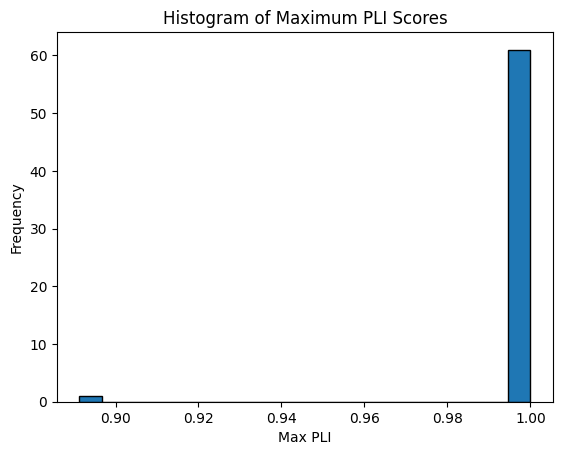

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))


    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()


main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Ensemble_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)


In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Ensemble_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")


Sum of Max PLI values: 61.891304347826086
Average PLI (sum divided by 62): 0.9982468443197756


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/pocket_RAPID_Majority0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv/pocket_RAPID_Majority0.pdb
PLI for pocket pocket_RAPID_Majority0.pdb: 1.000
Max PLI for subfolder /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/4phv: 1.000
Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2/1cge
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensembl

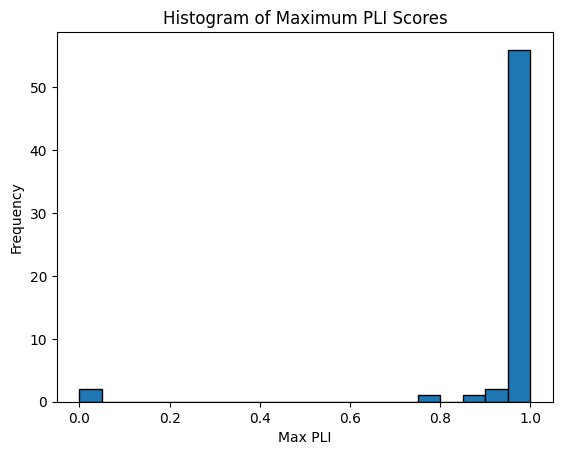

In [ ]:
#@title **Majority**
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and "Majority" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Ensemble_MAJORITY_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)


In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Ensemble_MAJORITY_max_pli_results.csv"
df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 59.389006457104536
Average PLI (sum divided by 62): 0.9578872009210408


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/4phv/pocket_RAPID_Model_1_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/4phv/pocket_RAPID_Model_1_Minimal0.pdb
PLI for pocket pocket_RAPID_Model_1_Minimal0.pdb: 1.000
Max PLI for subfolder /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/4phv: 1.000
Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2/1pdz
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48

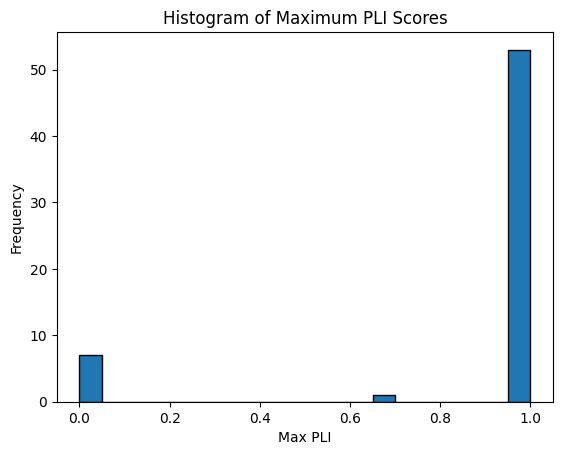

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_1/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_1_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_1_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 53.64450127877238
Average PLI (sum divided by 62): 0.8652338915931029


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/4phv/pocket_RAPID_Model_2_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/4phv/pocket_RAPID_Model_2_Minimal0.pdb
PLI for pocket pocket_RAPID_Model_2_Minimal0.pdb: 1.000
Max PLI for subfolder /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/4phv: 1.000
Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2/1hel
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48

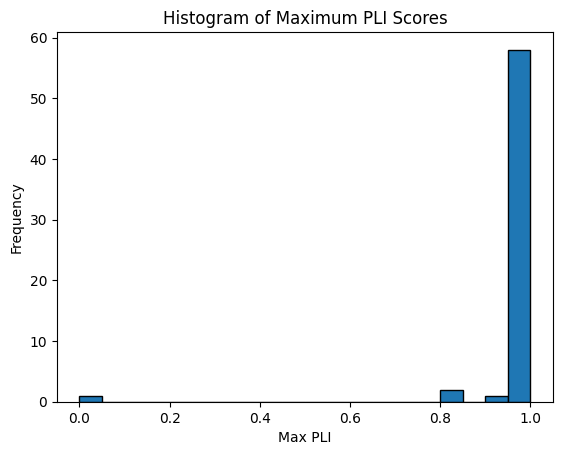

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    # Loop through all subfolders
    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            # Check if the subfolder contains a "protein" file
            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_2/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_2_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_2_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 60.4905640670039
Average PLI (sum divided by 62): 0.9756542591452242


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv/pocket_RAPID_Model_3_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv/pocket_RAPID_Model_3_Minimal0.pdb
PLI for pocket pocket_RAPID_Model_3_Minimal0.pdb: 1.000
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv/pocket_RAPID_Model_3_Minimal2.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2/4phv/pocket_RAPID_Model_3_Minimal2.pdb
PLI for pocket pocket_RAPID_Model_3_Minimal2.pdb: 0.000
Max PLI for subfolder /c

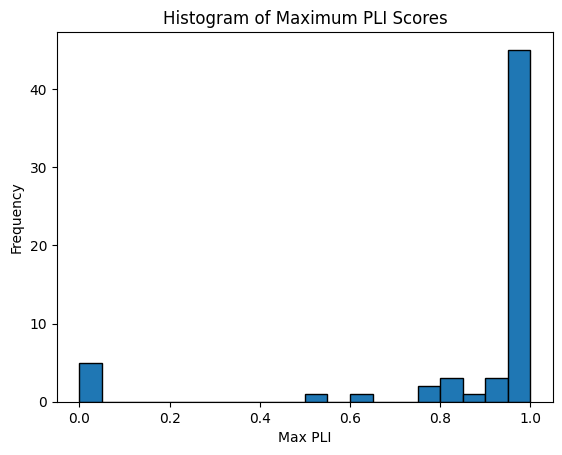

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_3/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_3_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_3_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 53.74013860448363
Average PLI (sum divided by 62): 0.8667764291045748


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/4phv/pocket_RAPID_Model_4_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/4phv/pocket_RAPID_Model_4_Minimal0.pdb
PLI for pocket pocket_RAPID_Model_4_Minimal0.pdb: 1.000
Max PLI for subfolder /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/4phv: 1.000
Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2/1rob
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48

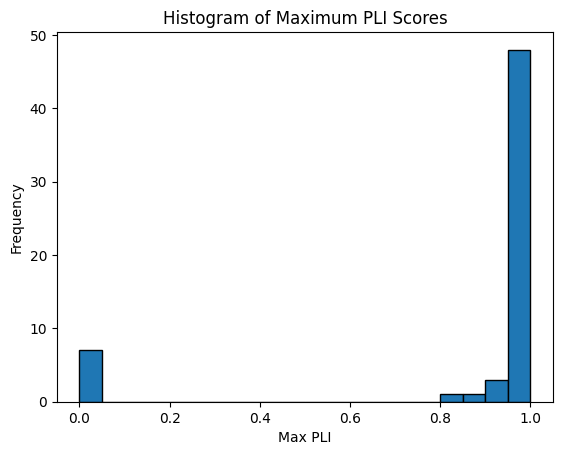

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_4/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_4_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_4_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 52.374184322717184
Average PLI (sum divided by 62): 0.8447449084309223


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv/pocket_RAPID_Model_5_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv/pocket_RAPID_Model_5_Minimal0.pdb
PLI for pocket pocket_RAPID_Model_5_Minimal0.pdb: 0.000
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv/pocket_RAPID_Model_5_Minimal2.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2/4phv/pocket_RAPID_Model_5_Minimal2.pdb
PLI for pocket pocket_RAPID_Model_5_Minimal2.pdb: 1.000
Max PLI for subfolder /c

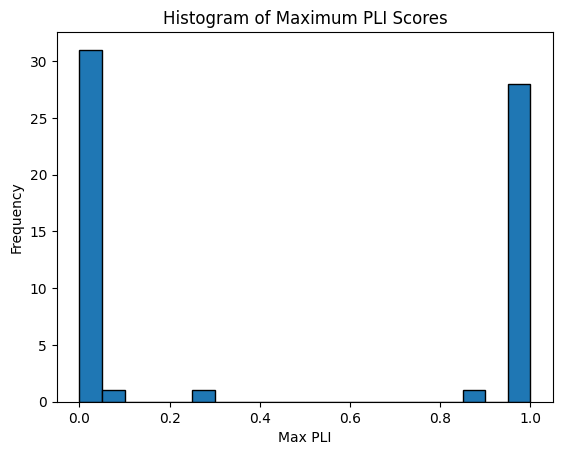

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Model_5/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_5_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_5_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 29.1194669374322
Average PLI (sum divided by 62): 0.4696688215714871


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/4phv/pocket_PUResNet_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/4phv/pocket_PUResNet_Minimal0.pdb
PLI for pocket pocket_PUResNet_Minimal0.pdb: 1.000
Max PLI for subfolder /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/4phv: 1.000
Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/1hfc
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2/1hfc
Read

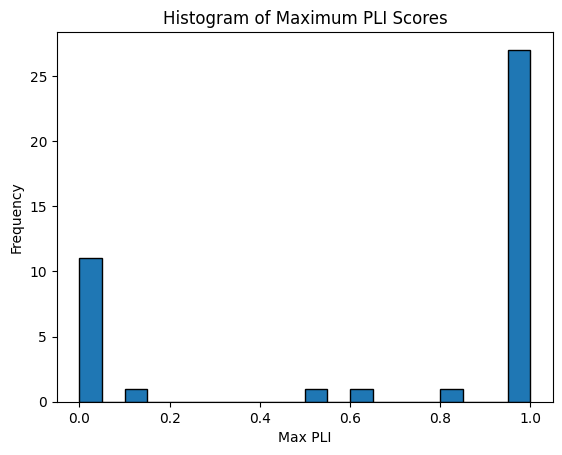

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_PUResNet_V1/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/PUResNet_max_pli_results.csv"

process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/PUResNet_max_pli_results.csv"

df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 29.077011150461317
Average PLI (sum divided by 62): 0.4689840508138922


Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/4phv
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/4phv
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/4phv/ligand.pdb
Loading pocket file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/4phv/pocket_Kalasanty_Minimal0.pdb
Reading coordinates from file: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/4phv/pocket_Kalasanty_Minimal0.pdb
PLI for pocket pocket_Kalasanty_Minimal0.pdb: 1.000
Max PLI for subfolder /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/4phv: 1.000
Checking subfolder: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/1apu
Protein file(s) found: ['protein.mol2', 'protein.pdb', 'protein_reduce.pdb']. Processing...
Processing subfolder: /content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2/1apu
Reading coordinat

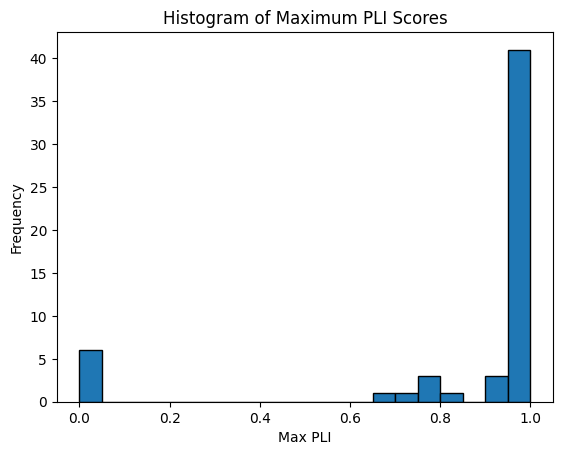

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def calculate_pli_based_on_distance(ligand, pocket, cutoff_distance):
    """
    Calculate the Protein-Ligand Interaction (PLI) score based on the percentage
    of ligand atoms within a specified cutoff distance of any pocket atom.
    """
    ligand_atoms_within_pocket = 0

    for ligand_atom in ligand.atom_coords:
        distances = np.linalg.norm(pocket.atom_coords - ligand_atom, axis=1)
        if np.any(distances <= cutoff_distance):
            ligand_atoms_within_pocket += 1

    total_ligand_atoms = len(ligand.atom_coords)
    if total_ligand_atoms == 0:
        return 0.0

    pli = ligand_atoms_within_pocket / total_ligand_atoms
    return pli

def coordinates(file_path, heavy_only=False):
    """
    Extract atomic coordinates from a molecular structure file.
    """
    print(f"Reading coordinates from file: {file_path}")
    molecule = pybel.readfile(file_path.split('.')[-1], file_path)
    for mol in molecule:
        if heavy_only:
            return np.array([atom.coords for atom in mol.atoms if atom.atomicnum > 1])
        else:
            return np.array([atom.coords for atom in mol.atoms])

def calculate_max_pli_for_subfolder(subdir_path, cutoff_distance=5.0):
    """
    Calculate the maximum PLI score for a single ligand pose and all pockets in a subfolder.
    """
    print(f"Processing subfolder: {subdir_path}")
    pocket_files = [file for file in os.listdir(subdir_path) if "pocket" in file and file.endswith(".pdb")]
    ligand_file_path = os.path.join(subdir_path, "ligand.pdb")

    if not os.path.exists(ligand_file_path):
        print(f"No ligand file found in {subdir_path}. Skipping...")
        return None

    if not pocket_files:
        print(f"No pocket files found in {subdir_path}. Skipping...")
        return None

    ligand_coords = coordinates(ligand_file_path, heavy_only=True)
    ligand = BindingPocket(ligand_coords)
    max_pli = 0

    for pocket_file in pocket_files:
        pocket_file_path = os.path.join(subdir_path, pocket_file)
        print(f"Loading pocket file: {pocket_file_path}")
        pocket_coords = coordinates(pocket_file_path, heavy_only=False)
        pocket = BindingPocket(pocket_coords)
        pli = calculate_pli_based_on_distance(ligand, pocket, cutoff_distance)
        print(f"PLI for pocket {pocket_file}: {pli:.3f}")
        max_pli = max(max_pli, pli)

    print(f"Max PLI for subfolder {subdir_path}: {max_pli:.3f}")
    return max_pli

def process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0):
    """
    Process all subfolders and calculate the maximum PLI for each subfolder containing 'protein' and 'ligand.pdb'.
    """
    results = []

    for subdir in os.listdir(main_folder):
        subdir_path = os.path.join(main_folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Checking subfolder: {subdir_path}")

            protein_files = [file for file in os.listdir(subdir_path) if "protein" in file]
            if not protein_files:
                print(f"No protein file found in {subdir_path}. Skipping...")
                continue

            print(f"Protein file(s) found: {protein_files}. Processing...")
            max_pli = calculate_max_pli_for_subfolder(subdir_path, cutoff_distance)
            results.append((subdir, max_pli))

    print(f"Saving results to CSV: {output_csv}")
    df = pd.DataFrame(results, columns=["Subfolder", "Max PLI"])
    df.to_csv(output_csv, index=False)

    pli_values = [res[1] for res in results if res[1] is not None]
    print(f"Plotting histogram for {len(pli_values)} PLI values")
    plt.hist(pli_values, bins=20, edgecolor='black')
    plt.xlabel("Max PLI")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum PLI Scores")
    histogram_path = output_csv.replace('.csv', '.png')
    plt.savefig(histogram_path)
    print(f"Histogram saved to: {histogram_path}")
    plt.show()

main_folder = "/content/gdrive/MyDrive/PUResNet/BU48_Kalasanty/bench2"
output_csv = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/Kalasanty_max_pli_results.csv"
process_all_subfolders(main_folder, output_csv, cutoff_distance=5.0)

In [ ]:
import pandas as pd

output_csv_path = "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/Kalasanty_max_pli_results.csv"
df = pd.read_csv(output_csv_path)

if "Max PLI" in df.columns:
    sum_max_pli = df["Max PLI"].sum()

    average_pli = sum_max_pli / 62

    print(f"Sum of Max PLI values: {sum_max_pli}")
    print(f"Average PLI (sum divided by 62): {average_pli}")
else:
    print(f"The column 'Max PLI' was not found in the file: {output_csv_path}")

Sum of Max PLI values: 48.23719305114008
Average PLI (sum divided by 62): 0.7780192427603239


Reading PLI values from: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/Kalasanty_max_pli_results.csv
File /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/Kalasanty_max_pli_results.csv has less than 62 entries. Padding missing values with zeros.
Reading PLI values from: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/PUResNet_max_pli_results.csv
File /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/PUResNet_max_pli_results.csv has less than 62 entries. Padding missing values with zeros.
Reading PLI values from: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_1_max_pli_results.csv
File /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_1_max_pli_results.csv has less than 62 entries. Padding missing values with zeros.
Reading PLI values from: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_2_max_pli_results.csv
Reading PLI values from: /content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_3_max_pli_results.csv

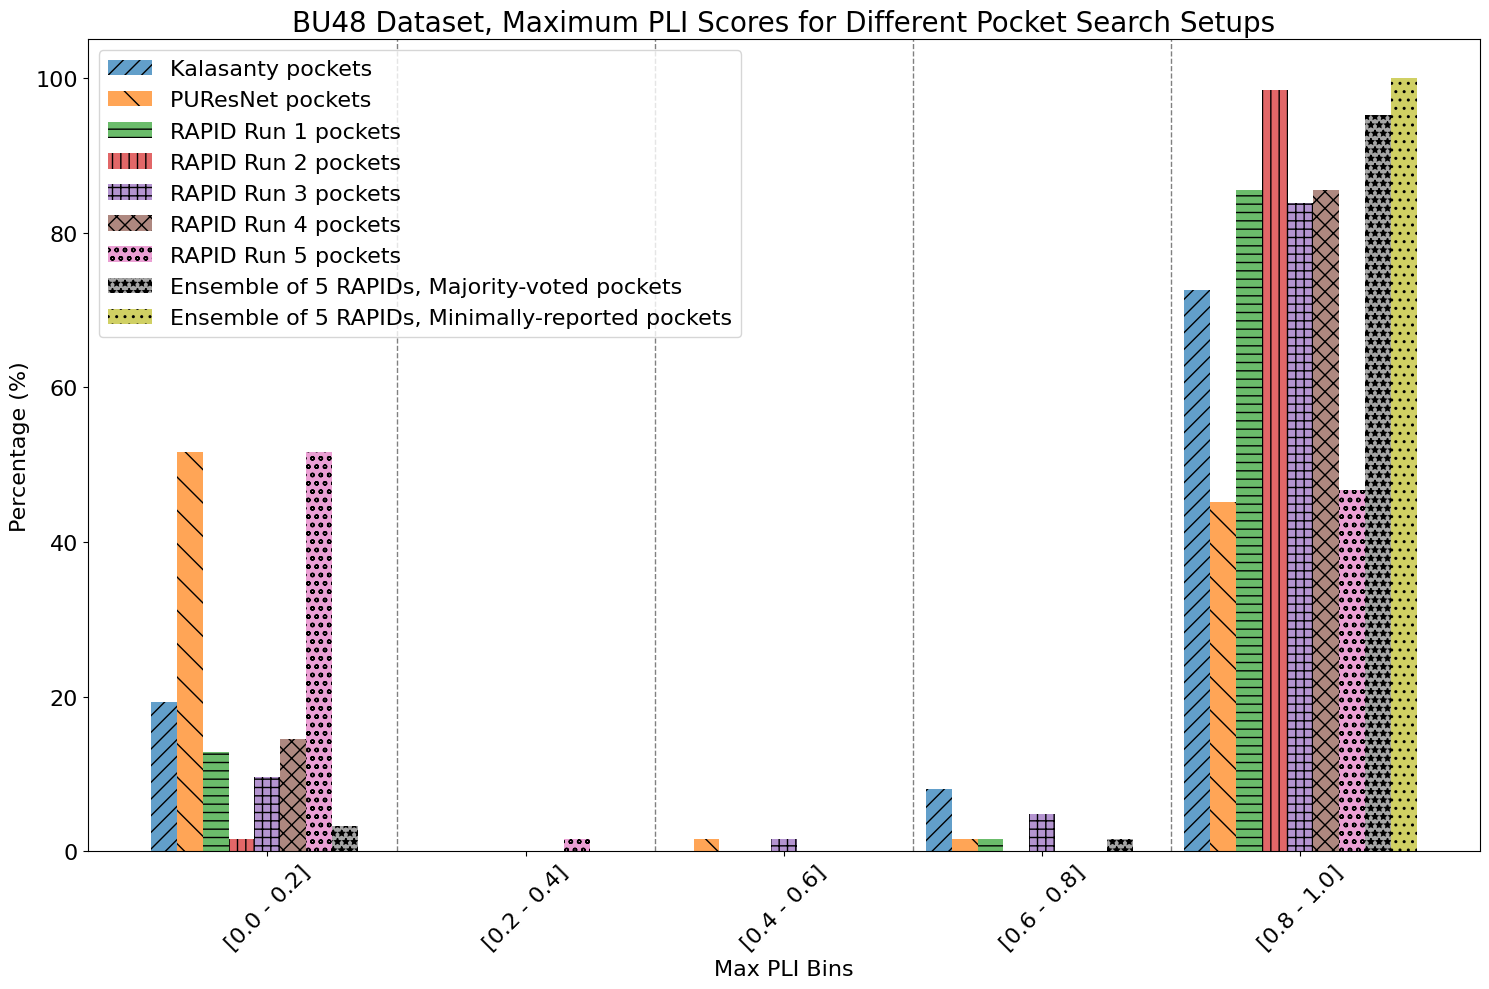

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class BindingPocket:
    def __init__(self, atom_coords):
        self.atom_coords = atom_coords

def plot_combined_bar_chart(csv_files, output_chart):
    """
    Plot a combined bar chart of PLI values from multiple CSV files, with each dataset shown side-by-side.

    Args:
        csv_files (list of str): List of paths to CSV files containing PLI results.
        output_chart (str): Path to save the output bar chart plot.
    """
    pli_data = []
    labels = [
        "Kalasanty pockets",
        "PUResNet pockets",
        "RAPID Run 1 pockets",
        "RAPID Run 2 pockets",
        "RAPID Run 3 pockets",
        "RAPID Run 4 pockets",
        "RAPID Run 5 pockets",
        "Ensemble of 5 RAPIDs, Majority-voted pockets",
        "Ensemble of 5 RAPIDs, Minimally-reported pockets"
    ]

    total_count = 62

    for csv_file in csv_files:
        print(f"Reading PLI values from: {csv_file}")
        df = pd.read_csv(csv_file)
        if "Max PLI" not in df.columns:
            print(f"Warning: 'Max PLI' column not found in {csv_file}")
            pli_data.append([0] * total_count)
            continue

        pli_values = df["Max PLI"].dropna().tolist()

        if len(pli_values) < total_count:
            print(f"File {csv_file} has less than {total_count} entries. Padding missing values with zeros.")
            pli_values.extend([0] * (total_count - len(pli_values)))

        pli_data.append(pli_values)

    if not pli_data:
        print("No valid PLI data found. Exiting.")
        return

    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    num_bins = len(bins) - 1
    bar_width = 0.1
    x_positions = np.arange(num_bins)

    plt.figure(figsize=(15, 10))

    hatches = ["//", "\\", "--", "||", "++", "xx", "oo", "**", ".."]

    for i, data in enumerate(pli_data):
        hist, _ = np.histogram(data, bins=bins)
        percentages = (hist / total_count) * 100
        bar_positions = x_positions + i * bar_width
        plt.bar(bar_positions, percentages, width=bar_width, label=labels[i], alpha=0.7, hatch=hatches[i % len(hatches)])

    for bin_edge in bins[1:-1]:
        plt.axvline(x=(bin_edge - 0.1 + 0.08) / (bins[-1] - bins[0]) * num_bins, color='gray', linestyle='--', linewidth=1)

    plt.xlabel("Max PLI Bins", fontsize=16)
    plt.ylabel("Percentage (%)", fontsize=16)
    plt.title("BU48 Dataset, Maximum PLI Scores for Different Pocket Search Setups", fontsize=20)
    plt.xticks(x_positions + bar_width * (len(pli_data) - 1) / 2, [f"[{bins[j]:.1f} - {bins[j+1]:.1f}]" for j in range(num_bins)], rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='upper left', fontsize=16)

    plt.tight_layout()
    plt.savefig(output_chart)
    print(f"Combined bar chart saved to: {output_chart}")
    plt.show()

csv_files = [
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/Kalasanty_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/PUResNet_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_1_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_2_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_3_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_4_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Model_5_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Ensemble_MAJORITY_max_pli_results.csv",
    "/content/gdrive/MyDrive/PUResNet/BU48_RAPID_Ensemble/RAPID_Ensemble_MINIMAL_max_pli_results.csv"
]


output_chart = "/content/gdrive/MyDrive/Docking_benchmarks/PB_new_run/combined_pli_bar_chart.png"
plot_combined_bar_chart(csv_files, output_chart)